In [1]:
import numpy as np
import torch
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt

torch.random.manual_seed(20092024)

### Data Preparation


In [2]:
dataset_df = pd.read_csv("diabetes.csv")
dataset_df.columns = dataset_df.columns.str.strip()
dataset_df.insert(0, 'Outcome', dataset_df.pop('Outcome'))

print(dataset_df.head())
print(dataset_df.describe())

   Outcome  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0        1            6      148             72             35        0  33.6   
1        0            1       85             66             29        0  26.6   
2        1            8      183             64              0        0  23.3   
3        0            1       89             66             23       94  28.1   
4        1            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  
0                     0.627   50  
1                     0.351   31  
2                     0.672   32  
3                     0.167   21  
4                     2.288   33  
          Outcome  Pregnancies     Glucose  BloodPressure  SkinThickness  \
count  768.000000   768.000000  768.000000     768.000000     768.000000   
mean     0.348958     3.845052  120.894531      69.105469      20.536458   
std      0.476951     3.369578   31.972618      19.355807      15.952218   

In [3]:
# Fix missing or zero values
fix_missing_cols = ['Glucose', 'BloodPressure', 'SkinThickness',
                    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

dataset_df[fix_missing_cols] = dataset_df[fix_missing_cols].replace(0, np.nan)
for col in fix_missing_cols:
    dataset_df[col] = dataset_df[col].fillna(dataset_df[col].mean())

print(dataset_df.describe())

          Outcome  Pregnancies     Glucose  BloodPressure  SkinThickness  \
count  768.000000   768.000000  768.000000     768.000000     768.000000   
mean     0.348958     3.845052  121.686763      72.405184      29.153420   
std      0.476951     3.369578   30.435949      12.096346       8.790942   
min      0.000000     0.000000   44.000000      24.000000       7.000000   
25%      0.000000     1.000000   99.750000      64.000000      25.000000   
50%      0.000000     3.000000  117.000000      72.202592      29.153420   
75%      1.000000     6.000000  140.250000      80.000000      32.000000   
max      1.000000    17.000000  199.000000     122.000000      99.000000   

          Insulin         BMI  DiabetesPedigreeFunction         Age  
count  768.000000  768.000000                768.000000  768.000000  
mean   155.548223   32.457464                  0.471876   33.240885  
std     85.021108    6.875151                  0.331329   11.760232  
min     14.000000   18.200000      

In [4]:
scaled_dataset_df = dataset_df.copy()

# standardize
for col in scaled_dataset_df.columns:
    if col == 'Outcome':
        continue
    scaled_dataset_df[col] = (
        scaled_dataset_df[col] - scaled_dataset_df[col].mean()) / scaled_dataset_df[col].std()

print(scaled_dataset_df.describe())

          Outcome   Pregnancies       Glucose  BloodPressure  SkinThickness  \
count  768.000000  7.680000e+02  7.680000e+02   7.680000e+02   7.680000e+02   
mean     0.348958 -7.864080e-17 -3.492577e-16   6.869505e-16   7.956598e-16   
std      0.476951  1.000000e+00  1.000000e+00   1.000000e+00   1.000000e+00   
min      0.000000 -1.141108e+00 -2.552467e+00  -4.001637e+00  -2.520028e+00   
25%      0.000000 -8.443348e-01 -7.207517e-01  -6.948531e-01  -4.724658e-01   
50%      0.000000 -2.507887e-01 -1.539877e-01  -1.674821e-02   8.082669e-16   
75%      1.000000  6.395305e-01  6.099116e-01   6.278603e-01   3.238084e-01   
max      1.000000  3.904034e+00  2.540195e+00   4.099983e+00   7.945290e+00   

            Insulin           BMI  DiabetesPedigreeFunction           Age  
count  7.680000e+02  7.680000e+02              7.680000e+02  7.680000e+02  
mean  -3.238150e-16  3.561966e-16              2.451743e-16  2.035409e-16  
std    1.000000e+00  1.000000e+00              1.000000e+00 

In [5]:
# https://discuss.pytorch.org/t/dataset-from-pandas-without-folder-structure/146816/4

from pandas import DataFrame


class DiabetesDataset(Dataset):
    def __init__(self, df: DataFrame):
        self.tensor = torch.tensor(df.to_numpy(dtype=np.float32))

    def __len__(self):
        return len(self.tensor)

    def __getitem__(self, idx):
        row = self.tensor[idx]
        return row[1:], row[0]

In [6]:
print(scaled_dataset_df['Outcome'].value_counts())

Outcome
0    500
1    268
Name: count, dtype: int64


In [7]:
# from sklearn.model_selection import StratifiedShuffleSplit

# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=20092024)

# train_idx, test_idx = next(sss.split(scaled_dataset_df.iloc[:, 1:], scaled_dataset_df['Outcome']))

# train_df = scaled_dataset_df.iloc[train_idx]
# test_df = scaled_dataset_df.iloc[test_idx]

# train_dataset = DiabetesDataset(train_df)
# test_dataset = DiabetesDataset(test_df)

# print(train_df['Outcome'].value_counts())
# print(test_df['Outcome'].value_counts())

In [8]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=8, random_state=20092024, shuffle=True)

folds = []

for i, (train_idx, test_idx) in enumerate(skf.split(scaled_dataset_df.iloc[:, 1:], scaled_dataset_df['Outcome'])):
    train_i_df = scaled_dataset_df.iloc[train_idx]
    test_i_df = scaled_dataset_df.iloc[test_idx]

    train_i_dataset = DiabetesDataset(train_i_df)
    test_i_dataset = DiabetesDataset(test_i_df)

    folds.append((train_i_dataset, test_i_dataset))

    print(f"Fold {i}")
    counts = train_i_df['Outcome'].value_counts()
    print(f"Train split: {counts[0]}, {counts[1]}")
    counts = test_i_df['Outcome'].value_counts()
    print(f"Test split: {counts[0]}, {counts[1]}")

Fold 0
Train split: 438, 234
Test split: 62, 34
Fold 1
Train split: 438, 234
Test split: 62, 34
Fold 2
Train split: 438, 234
Test split: 62, 34
Fold 3
Train split: 438, 234
Test split: 62, 34
Fold 4
Train split: 437, 235
Test split: 63, 33
Fold 5
Train split: 437, 235
Test split: 63, 33
Fold 6
Train split: 437, 235
Test split: 63, 33
Fold 7
Train split: 437, 235
Test split: 63, 33


### Evaluation Functions


In [9]:
def evaluate(evals: DataFrame, dataset, predict_fn, epoch, negative_label=0, positive_label=1) -> DataFrame:
    """Evalue a model on a dataset."""
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for xi, yi in dataset:
        yi_pred = predict_fn(xi)
        if yi == negative_label:
            if yi_pred == negative_label:
                tn += 1
            else:
                fp += 1
        else:
            if yi_pred == positive_label:
                tp += 1
            else:
                fn += 1

    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) else 0
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

    results = pd.DataFrame({
        'epoch': [epoch],
        'accuracy': [accuracy],
        'precision': [precision],
        'recall': [recall],
        'f1': [f1],
    })

    return pd.concat([evals, results], ignore_index=True)

In [10]:
def plot_evals_individual(test_evals, train_evals):
    plt.title('Accuracy')
    plt.ylim(0, 1)
    plt.plot(test_evals['epoch'], test_evals['accuracy'],
             label='Test Accuracy')
    plt.plot(train_evals['epoch'],
             train_evals['accuracy'], label='Train Accuracy')
    plt.legend()
    plt.show()

    plt.title('Precision')
    plt.ylim(0, 1)
    plt.plot(test_evals['epoch'], test_evals['precision'],
             label='Test Precision')
    plt.plot(train_evals['epoch'],
             train_evals['precision'], label='Train Precision')
    plt.legend()
    plt.show()

    plt.title('Recall')
    plt.ylim(0, 1)
    plt.plot(test_evals['epoch'], test_evals['recall'], label='Test Recall')
    plt.plot(train_evals['epoch'], train_evals['recall'], label='Train Recall')
    plt.legend()
    plt.show()

    plt.title('F1')
    plt.ylim(0, 1)
    plt.plot(test_evals['epoch'], test_evals['f1'], label='Test F1')
    plt.plot(train_evals['epoch'], train_evals['f1'], label='Train F1')
    plt.legend()
    plt.show()

In [11]:
def plot_evals_subplot(test_evals, train_evals):
    fig, axs = plt.subplots(2, 2)
    fig.suptitle('Metrics')
    axs[0, 0].set_ylim(0, 1)
    axs[0, 0].plot(test_evals['epoch'], test_evals['accuracy'],
                   label='Test Accuracy')
    axs[0, 0].plot(train_evals['epoch'],
                   train_evals['accuracy'], label='Train Accuracy')
    axs[0, 0].legend()
    axs[0, 0].set_title('Accuracy')

    axs[0, 1].set_ylim(0, 1)
    axs[0, 1].plot(test_evals['epoch'], test_evals['f1'], label='Test F1')
    axs[0, 1].plot(train_evals['epoch'], train_evals['f1'], label='Train F1')
    axs[0, 1].legend()
    axs[0, 1].set_title('F1')

    axs[1, 0].set_ylim(0, 1)
    axs[1, 0].plot(test_evals['epoch'],
                   test_evals['recall'], label='Test Recall')
    axs[1, 0].plot(train_evals['epoch'],
                   train_evals['recall'], label='Train Recall')
    axs[1, 0].legend()
    axs[1, 0].set_title('Recall')

    axs[1, 1].set_ylim(0, 1)
    axs[1, 1].plot(test_evals['epoch'], test_evals['precision'],
                   label='Test Precision')
    axs[1, 1].plot(train_evals['epoch'],
                   train_evals['precision'], label='Train Precision')
    axs[1, 1].legend()
    axs[1, 1].set_title('Precision')

    fig.set_figheight(8)
    fig.set_figwidth(15)
    plt.show()

In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score


def plot_pr_curve(fold_test_sets, fold_models, title=""):
    """
    Draw a Cross Validated PR Curve.
    Largely taken from: https://stackoverflow.com/questions/29656550/how-to-plot-pr-curve-over-10-folds-of-cross-validation-in-scikit-learn
    """
    all_y_real = []
    all_y_probs = []
    for i, (test_dataset, model) in enumerate(zip(fold_test_sets, fold_models)):
        X, y = zip(*[(xi, yi.item()) for xi, yi in test_dataset])

        probs = [model.predict_prob(xi) for xi in X]

        precision, recall, _ = precision_recall_curve(y, probs)

        plt.plot(recall, precision, lw=1, alpha=0.3,
                 label='PR fold %d (AUC = %0.2f)' % (i, average_precision_score(y, probs)))

        all_y_real.append(y)
        all_y_probs.append(probs)

    all_y_real = np.concatenate(all_y_real)
    all_y_probs = np.concatenate(all_y_probs)

    all_precision, all_recall, _ = precision_recall_curve(
        all_y_real, all_y_probs)

    plt.plot(all_recall, all_precision, color='b',
             label=r'Precision-Recall (AUC = %0.2f)' % (
                 average_precision_score(all_y_real, all_y_probs)),
             lw=2, alpha=.8)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title + ' PR Curve')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
def table_metrics(fold_evals):
    final_metrics = []
    for (test_evals, _) in fold_evals:
        final_metrics.append(test_evals.iloc[-1])

    print(pd.DataFrame(final_metrics).describe())
    return pd.DataFrame(final_metrics)

In [14]:
eval_dtypes = {
    'epoch': 'int64',
    'accuracy': 'float64',
    'f1': 'float64',
    'recall': 'float64',
    'precision': 'float64',
}


def train_model(
        update_fn,
        predict_fn,
        train_dataset,
        test_dataset,
        t=0,
        epochs=100,
        lr=0.01,
        test_period=10,
        negative_label=0,
        lr_decay=1.0,
        step=10,
):
    test_evals = pd.DataFrame({col: pd.Series(dtype=dtype) for col, dtype in eval_dtypes.items()})
    train_evals = pd.DataFrame({col: pd.Series(dtype=dtype) for col, dtype in eval_dtypes.items()})

    test_evals = evaluate(test_evals, test_dataset, predict_fn, t, negative_label=negative_label)
    train_evals = evaluate(train_evals, train_dataset, predict_fn, t, negative_label=negative_label)

    for _ in range(epochs):
        update_fn(lr, train_dataset)
        t += 1

        if t % step == 0:
            lr *= lr_decay

        if t % test_period == 0:
            test_evals = evaluate(test_evals, test_dataset, predict_fn, t, negative_label=negative_label)
            train_evals = evaluate(train_evals, train_dataset, predict_fn, t, negative_label=negative_label)
            test_acc = test_evals.loc[test_evals.index[-1], 'accuracy']
            train_acc = train_evals.loc[train_evals.index[-1], 'accuracy']
            print(f"t={t} Test Acc: {test_acc:0.3f} Train Acc: {train_acc:0.3f}")

    return test_evals, train_evals

### Model Implementations


In [52]:
class BasePerceptronNeg():
    weights: torch.Tensor

    def __init__(self, size: int):
        self.weights = torch.zeros(size)

    def update(self, learning_rate: float, dataset: Dataset):
        sm = torch.zeros(len(self.weights))
        for xi, yi in dataset:

            cond = yi * torch.dot(xi, self.weights)
            indicate = 1 if cond <= 0 else 0
            adjust = yi * xi

            sm += adjust * indicate

        self.weights = self.weights + learning_rate * sm

    def predict_prob(self, new_X: torch.Tensor):
        return torch.dot(new_X, self.weights)

    def predict(self, new_X: torch.Tensor):
        return 1 if self.predict_prob(new_X) > 0 else -1


class BasePerceptronWrongButOk():
    weights: torch.Tensor

    def __init__(self, size: int):
        self.weights = torch.zeros(size)

    def update(self, learning_rate: float, dataset: Dataset):
        sm = torch.zeros(len(self.weights))
        for xi, yi in dataset:

            cond = yi * torch.dot(xi, self.weights)
            indicate = 1 if (yi == 1 and cond < 0.5) or (
                yi == 0 and cond >= 0.5) else 0

            adjust = yi * xi

            sm += adjust * indicate

        self.weights = self.weights + learning_rate * sm

    def predict_prob(self, new_X: torch.Tensor):
        return torch.dot(new_X, self.weights)

    def predict(self, new_X: torch.Tensor):
        return 1 if self.predict_prob(new_X) >= 0.5 else 0


class BasePerceptron():
    weights: torch.Tensor

    def __init__(self, size: int):
        self.weights = torch.zeros(size)

    def update(self, learning_rate: float, dataset: Dataset):
        for xi, yi in dataset:
            y_mapped = 2 * yi - 1
            cond = y_mapped * torch.dot(xi, self.weights)
            if cond <= 0:
                self.weights += learning_rate * y_mapped * xi

    def predict_prob(self, new_X: torch.Tensor):
        return torch.dot(new_X, self.weights)

    def predict(self, new_X: torch.Tensor):
        return 1 if self.predict_prob(new_X) >= 0 else 0


class BasePerceptronWithBias():
    weights: torch.Tensor

    def __init__(self, size: int):
        self.weights = torch.zeros(size + 1)

    def update(self, learning_rate: float, dataset: Dataset):
        for xi, yi in dataset:
            xi = torch.cat((xi, torch.tensor([1.0])))
            y_mapped = 2 * yi - 1
            cond = y_mapped * torch.dot(xi, self.weights)
            if cond <= 0:
                self.weights += learning_rate * y_mapped * xi

    def predict_prob(self, new_X: torch.Tensor):
        new_X = torch.cat((new_X, torch.tensor([1.0])))
        return torch.dot(new_X, self.weights)

    def predict(self, new_X: torch.Tensor):
        return 1 if self.predict_prob(new_X) >= 0 else 0


class PerceptronWithClassWeighting():
    weights: torch.Tensor

    def __init__(self, size: int, l2_lambda=0.01, class_weights=(1, 1)):
        self.weights = torch.zeros(size + 1)
        self.l2_lambda = l2_lambda
        self.class_weights = class_weights

    def update(self, learning_rate: float, dataset: Dataset):
        for xi, yi in dataset:
            xi = torch.cat((xi, torch.tensor([1.0])))
            y_mapped = 2 * yi - 1
            cond = y_mapped * torch.dot(xi, self.weights)
            if cond <= 0:
                regularization_term = self.l2_lambda * self.weights
                regularization_term[-1] = 0

                class_weight = self.class_weights[int(yi)]

                self.weights += learning_rate * y_mapped * \
                    xi * class_weight - regularization_term

    def predict_prob(self, new_X: torch.Tensor):
        new_X = torch.cat((new_X, torch.tensor([1.0])))
        return torch.dot(new_X, self.weights)

    def predict(self, new_X: torch.Tensor):
        return 1 if self.predict_prob(new_X) >= 0 else 0


class PerceptronWithGDTanh():
    weights: torch.Tensor

    def __init__(self, size: int, l2_lambda=0.01, class_weights=(1, 1), activation=torch.tanh):
        self.weights = torch.randn(size)
        self.b = 0
        self.l2_lambda = l2_lambda
        self.class_weights = class_weights
        self.activation = activation

    def batch_update(self, learning_rate: float, dataset: Dataset):
        loader = DataLoader(dataset, batch_size=32, shuffle=True)

        for X, y in loader:

            y_mapped = 2 * y - 1

            comb = torch.matmul(X, self.weights) + self.b

            y_pred = self.activation(comb)

            diff = y_mapped - y_pred

            weighted_diff = torch.where(
                y_mapped == 1, diff * self.class_weights[1], diff * self.class_weights[0])

            regularization_term = 2 * self.l2_lambda * self.weights

            self.weights += learning_rate * \
                (torch.matmul(X.T, weighted_diff) - regularization_term)
            self.b += learning_rate * torch.sum(weighted_diff)

    def predict_prob(self, new_X: torch.Tensor):
        return self.activation(torch.dot(new_X, self.weights) + self.b)

    def predict(self, new_X: torch.Tensor, threshold=0.0):
        return 1 if self.predict_prob(new_X) >= threshold else 0


class PerceptronWithGD():
    weights: torch.Tensor

    def __init__(self, size: int, l2_lambda=0.01, class_weights=(1, 1), activation=torch.sigmoid):
        self.weights = torch.randn(size)
        self.b = 0
        self.l2_lambda = l2_lambda
        self.class_weights = class_weights
        self.activation = activation

    def update(self, learning_rate: float, dataset: Dataset):
        X = torch.stack([xi for xi, yi in dataset])
        y = torch.tensor([yi for xi, yi in dataset])

        comb = torch.matmul(X, self.weights) + self.b

        y_pred = self.activation(comb)

        diff = y - y_pred

        weighted_diff = torch.where(
            y == 1, diff * self.class_weights[1], diff * self.class_weights[0])

        regularization_term = 2 * self.l2_lambda * self.weights

        self.weights += learning_rate * \
            (torch.matmul(X.T, weighted_diff) - regularization_term)
        self.b += learning_rate * torch.sum(weighted_diff)

    def batch_update(self, learning_rate: float, dataset: Dataset):
        loader = DataLoader(dataset, batch_size=32, shuffle=True)

        for X, y in loader:

            comb = torch.matmul(X, self.weights) + self.b

            y_pred = self.activation(comb)

            diff = y - y_pred

            weighted_diff = torch.where(
                y == 1, diff * self.class_weights[1], diff * self.class_weights[0])

            regularization_term = 2 * self.l2_lambda * self.weights

            self.weights += learning_rate * \
                (torch.matmul(X.T, weighted_diff) - regularization_term)
            self.b += learning_rate * torch.sum(weighted_diff)

    def predict_prob(self, new_X: torch.Tensor):
        return self.activation(torch.dot(new_X, self.weights) + self.b)

    def predict(self, new_X: torch.Tensor, threshold=0.5):
        return 1 if self.predict_prob(new_X) >= threshold else 0

### Experiments and Testing


##### Baseline Perceptron


In [16]:
lr = 0.01
epochs = 300
baseline_fold_evals = []
baseline_fold_models = []

for i, (train_dataset, test_dataset) in enumerate(folds):
    print(f"Fold {i}")
    model = BasePerceptron(len(train_dataset[0][0]))
    epoch = 0

    test_evals, train_evals = train_model(
        model.update, model.predict, train_dataset, test_dataset, epoch, epochs, lr, 10)

    baseline_fold_evals.append((test_evals, train_evals))
    baseline_fold_models.append(model)

Fold 0
t=10 Test Acc: 0.771 Train Acc: 0.704
t=20 Test Acc: 0.729 Train Acc: 0.676
t=30 Test Acc: 0.656 Train Acc: 0.643
t=40 Test Acc: 0.708 Train Acc: 0.713
t=50 Test Acc: 0.729 Train Acc: 0.725
t=60 Test Acc: 0.740 Train Acc: 0.702
t=70 Test Acc: 0.688 Train Acc: 0.714
t=80 Test Acc: 0.667 Train Acc: 0.726
t=90 Test Acc: 0.719 Train Acc: 0.662
t=100 Test Acc: 0.708 Train Acc: 0.659
t=110 Test Acc: 0.594 Train Acc: 0.683
t=120 Test Acc: 0.729 Train Acc: 0.668
t=130 Test Acc: 0.667 Train Acc: 0.722
t=140 Test Acc: 0.708 Train Acc: 0.734
t=150 Test Acc: 0.708 Train Acc: 0.686
t=160 Test Acc: 0.750 Train Acc: 0.698
t=170 Test Acc: 0.740 Train Acc: 0.710
t=180 Test Acc: 0.719 Train Acc: 0.714
t=190 Test Acc: 0.677 Train Acc: 0.698
t=200 Test Acc: 0.646 Train Acc: 0.616
t=210 Test Acc: 0.729 Train Acc: 0.683
t=220 Test Acc: 0.667 Train Acc: 0.689
t=230 Test Acc: 0.708 Train Acc: 0.673
t=240 Test Acc: 0.740 Train Acc: 0.665
t=250 Test Acc: 0.625 Train Acc: 0.619
t=260 Test Acc: 0.708 Train

       epoch  accuracy        f1    recall  precision
count    8.0  8.000000  8.000000  8.000000   8.000000
mean   300.0  0.704427  0.623876  0.704991   0.562813
std      0.0  0.058380  0.077152  0.103449   0.074846
min    300.0  0.604167  0.486486  0.545455   0.439024
25%    300.0  0.661458  0.596230  0.651292   0.504148
50%    300.0  0.729167  0.653058  0.720588   0.593237
75%    300.0  0.744792  0.669014  0.770499   0.612722
max    300.0  0.760417  0.708861  0.848485   0.648649


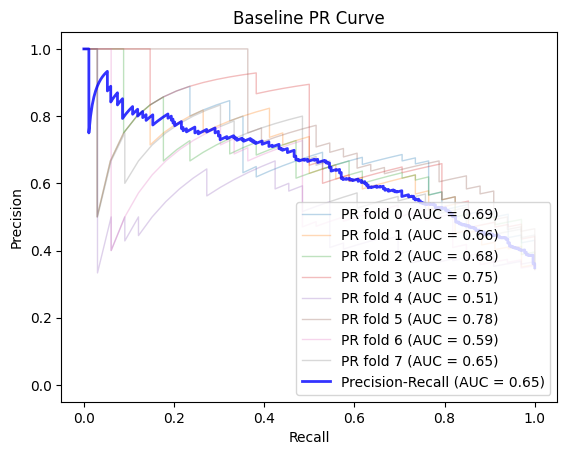

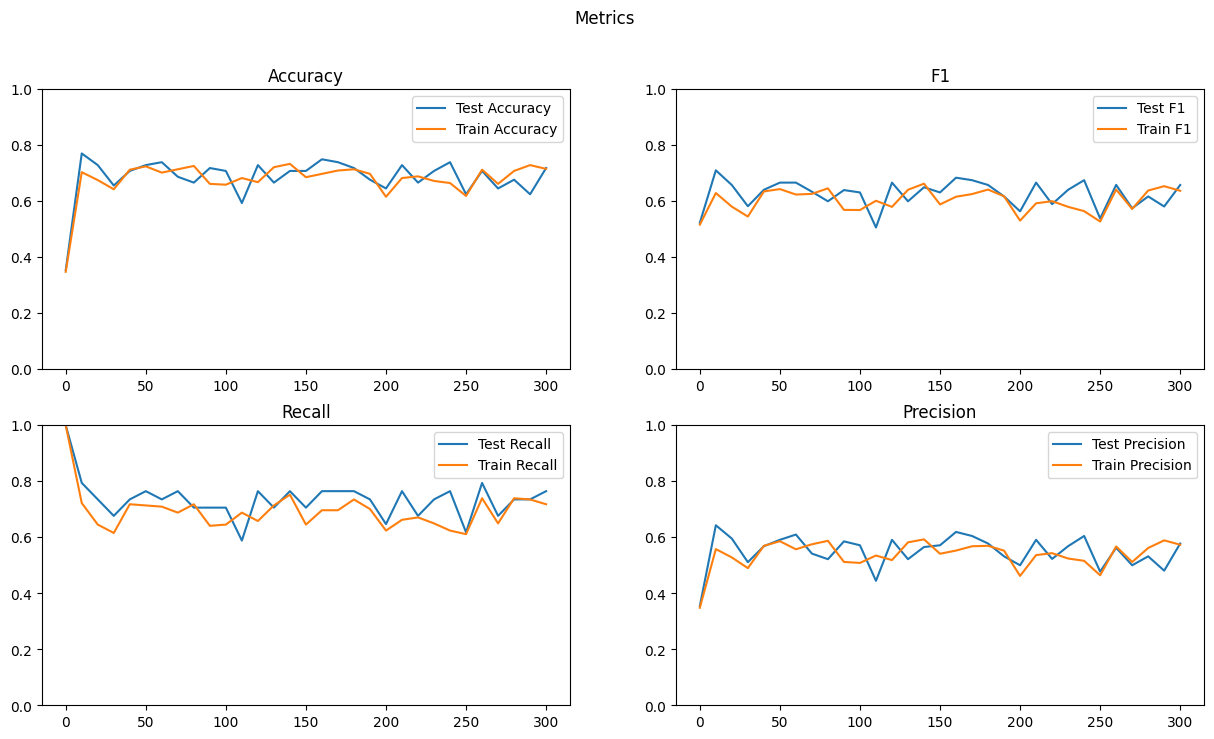

In [17]:
table_metrics(baseline_fold_evals)
plot_pr_curve([test_dataset for _, test_dataset in folds], baseline_fold_models, 'Baseline')
plot_evals_subplot(baseline_fold_evals[0][0], baseline_fold_evals[0][1])

##### Baseline With Bias


In [37]:
lr = 0.01
epochs = 200
with_bias_fold_evals = []
with_bias_fold_models = []

for i, (train_dataset, test_dataset) in enumerate(folds):
    print(f"Fold {i}")
    model = BasePerceptronWithBias(len(train_dataset[0][0]))
    epoch = 0

    test_evals, train_evals = train_model(
        model.update, model.predict, train_dataset, test_dataset, epoch, epochs, lr, 10)

    with_bias_fold_evals.append((test_evals, train_evals))
    with_bias_fold_models.append(model)

Fold 0
t=10 Test Acc: 0.698 Train Acc: 0.707
t=20 Test Acc: 0.760 Train Acc: 0.759
t=30 Test Acc: 0.698 Train Acc: 0.683
t=40 Test Acc: 0.656 Train Acc: 0.704
t=50 Test Acc: 0.719 Train Acc: 0.713
t=60 Test Acc: 0.740 Train Acc: 0.716
t=70 Test Acc: 0.781 Train Acc: 0.735
t=80 Test Acc: 0.729 Train Acc: 0.738
t=90 Test Acc: 0.656 Train Acc: 0.726
t=100 Test Acc: 0.708 Train Acc: 0.726
t=110 Test Acc: 0.698 Train Acc: 0.743
t=120 Test Acc: 0.667 Train Acc: 0.680
t=130 Test Acc: 0.667 Train Acc: 0.710
t=140 Test Acc: 0.656 Train Acc: 0.699
t=150 Test Acc: 0.688 Train Acc: 0.702
t=160 Test Acc: 0.729 Train Acc: 0.699
t=170 Test Acc: 0.729 Train Acc: 0.716
t=180 Test Acc: 0.760 Train Acc: 0.726
t=190 Test Acc: 0.656 Train Acc: 0.662
t=200 Test Acc: 0.729 Train Acc: 0.722
Fold 1
t=10 Test Acc: 0.594 Train Acc: 0.699
t=20 Test Acc: 0.615 Train Acc: 0.682
t=30 Test Acc: 0.625 Train Acc: 0.716
t=40 Test Acc: 0.615 Train Acc: 0.613
t=50 Test Acc: 0.615 Train Acc: 0.711
t=60 Test Acc: 0.708 Trai

       epoch  accuracy        f1    recall  precision
count    8.0  8.000000  8.000000  8.000000   8.000000
mean   200.0  0.704427  0.564860  0.548574   0.589822
std      0.0  0.072370  0.092018  0.100008   0.109665
min    200.0  0.552083  0.410959  0.424242   0.384615
25%    200.0  0.692708  0.512903  0.473930   0.565134
50%    200.0  0.729167  0.601276  0.544118   0.608586
75%    200.0  0.744792  0.618681  0.616310   0.648157
max    200.0  0.770833  0.676471  0.696970   0.739130


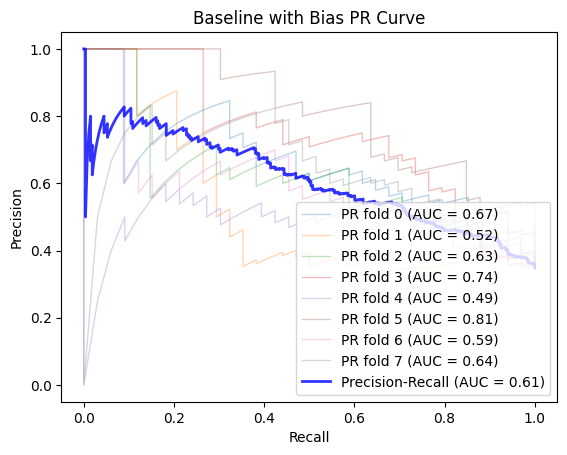

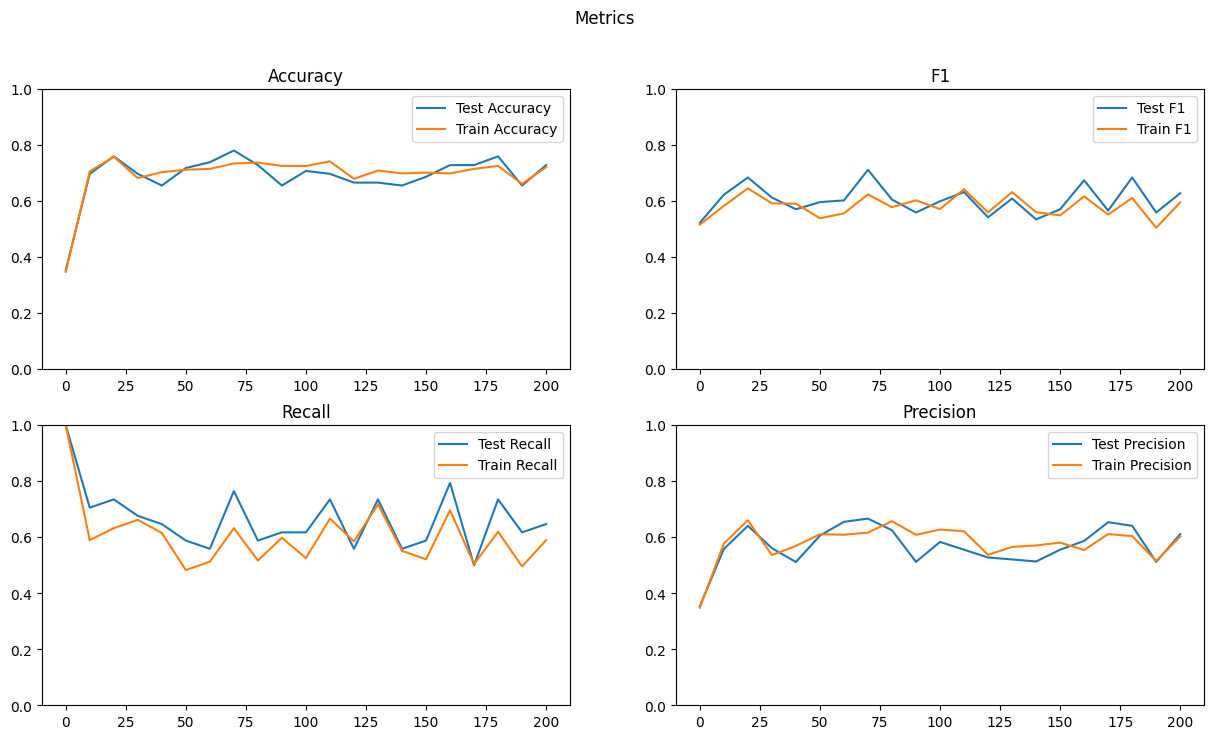

In [48]:
table_metrics(with_bias_fold_evals)
plot_pr_curve([test_dataset for _, test_dataset in folds], with_bias_fold_models, 'Baseline with Bias')
plot_evals_subplot(with_bias_fold_evals[0][0], with_bias_fold_evals[0][1])

##### Baseline With Bias and Regularisation

In [47]:
lr = 0.01
epochs = 300
with_bias_and_reg_fold_evals = []
with_bias_and_reg_fold_models = []

for i, (train_dataset, test_dataset) in enumerate(folds):
    print(f"Fold {i}")
    model = PerceptronWithClassWeighting(len(train_dataset[0][0]), 0.01)
    epoch = 0

    test_evals, train_evals = train_model(
        model.update, model.predict, train_dataset, test_dataset, epoch, epochs, lr, 10)

    with_bias_and_reg_fold_evals.append((test_evals, train_evals))
    with_bias_and_reg_fold_models.append(model)

Fold 0
t=10 Test Acc: 0.719 Train Acc: 0.698
t=20 Test Acc: 0.646 Train Acc: 0.696
t=30 Test Acc: 0.729 Train Acc: 0.723
t=40 Test Acc: 0.677 Train Acc: 0.688
t=50 Test Acc: 0.688 Train Acc: 0.734
t=60 Test Acc: 0.677 Train Acc: 0.702
t=70 Test Acc: 0.635 Train Acc: 0.723
t=80 Test Acc: 0.677 Train Acc: 0.650
t=90 Test Acc: 0.760 Train Acc: 0.746
t=100 Test Acc: 0.677 Train Acc: 0.699
t=110 Test Acc: 0.708 Train Acc: 0.711
t=120 Test Acc: 0.635 Train Acc: 0.628
t=130 Test Acc: 0.719 Train Acc: 0.676
t=140 Test Acc: 0.729 Train Acc: 0.738
t=150 Test Acc: 0.656 Train Acc: 0.695
t=160 Test Acc: 0.677 Train Acc: 0.720
t=170 Test Acc: 0.677 Train Acc: 0.729
t=180 Test Acc: 0.677 Train Acc: 0.701
t=190 Test Acc: 0.646 Train Acc: 0.711
t=200 Test Acc: 0.729 Train Acc: 0.757
t=210 Test Acc: 0.708 Train Acc: 0.696
t=220 Test Acc: 0.708 Train Acc: 0.720
t=230 Test Acc: 0.740 Train Acc: 0.726
t=240 Test Acc: 0.708 Train Acc: 0.711
t=250 Test Acc: 0.656 Train Acc: 0.705
t=260 Test Acc: 0.698 Train

       epoch  accuracy        f1    recall  precision
count    8.0  8.000000  8.000000  8.000000   8.000000
mean   300.0  0.704427  0.569330  0.574978   0.583546
std      0.0  0.026079  0.070373  0.130580   0.053829
min    300.0  0.666667  0.461538  0.352941   0.518519
25%    300.0  0.687500  0.542040  0.503119   0.546221
50%    300.0  0.703125  0.587620  0.611408   0.566912
75%    300.0  0.713542  0.609353  0.681595   0.626931
max    300.0  0.750000  0.657143  0.696970   0.666667


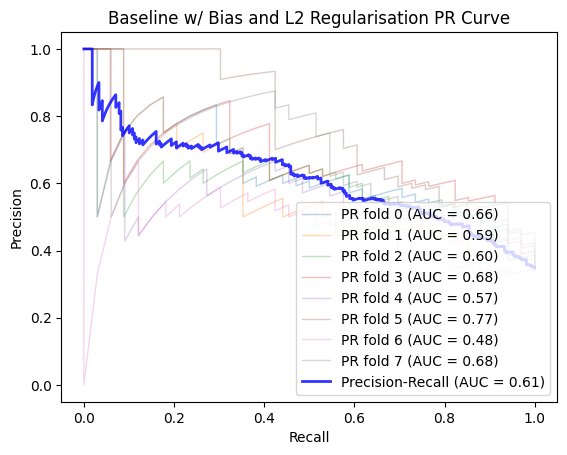

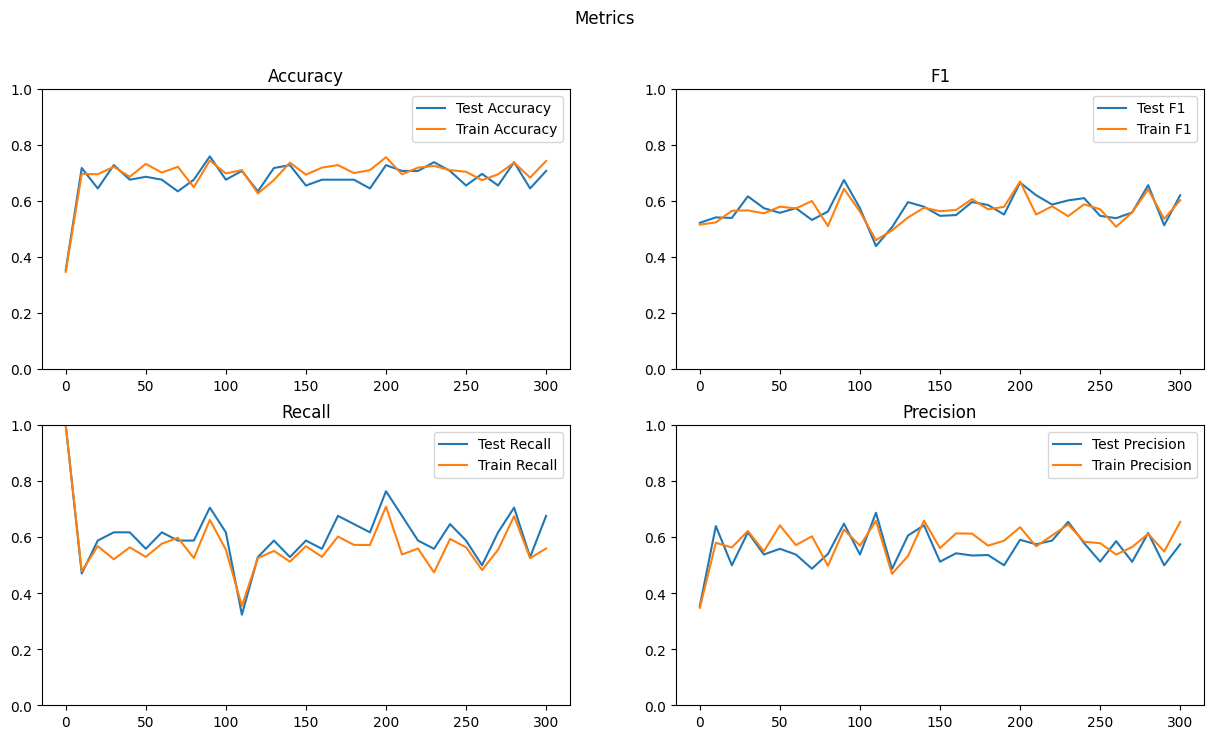

In [49]:
table_metrics(with_bias_and_reg_fold_evals)
plot_pr_curve([test_dataset for _, test_dataset in folds], with_bias_and_reg_fold_models, 'Baseline w/ Bias and L2 Regularisation')
plot_evals_subplot(with_bias_and_reg_fold_evals[0][0], with_bias_and_reg_fold_evals[0][1])

##### Baseline w/ Bias and Class Weighting 

In [50]:
def calc_class_weights(dataset):
    class_counts = [0, 0]
    for _, yi in dataset:
        class_counts[int(yi)] += 1

    class_weight_0 = len(dataset) / (class_counts[0] * 2)
    class_weight_1 = len(dataset) / (class_counts[1] * 2)
    print(f"Class weights: {class_weight_0}, {class_weight_1}")

    return class_weight_0, class_weight_1


lr = 0.01
epochs = 200
class_weights_fold_evals = []
class_weights_fold_models = []

for i, (train_dataset, test_dataset) in enumerate(folds):
    print(f"Fold {i}")

    class_weights = calc_class_weights(train_dataset)
    model = PerceptronWithClassWeighting(len(train_dataset[0][0]), 0.00, class_weights=class_weights)
    epoch = 0

    test_evals, train_evals = train_model(
        model.update, model.predict, train_dataset, test_dataset, epoch, epochs, lr, 10)

    class_weights_fold_evals.append((test_evals, train_evals))
    class_weights_fold_models.append(model)

Fold 0
Class weights: 0.7671232876712328, 1.435897435897436
t=10 Test Acc: 0.583 Train Acc: 0.661
t=20 Test Acc: 0.792 Train Acc: 0.720
t=30 Test Acc: 0.708 Train Acc: 0.665
t=40 Test Acc: 0.719 Train Acc: 0.743
t=50 Test Acc: 0.635 Train Acc: 0.612
t=60 Test Acc: 0.708 Train Acc: 0.704
t=70 Test Acc: 0.740 Train Acc: 0.668
t=80 Test Acc: 0.646 Train Acc: 0.717
t=90 Test Acc: 0.708 Train Acc: 0.707
t=100 Test Acc: 0.698 Train Acc: 0.655
t=110 Test Acc: 0.729 Train Acc: 0.720
t=120 Test Acc: 0.750 Train Acc: 0.747
t=130 Test Acc: 0.719 Train Acc: 0.702
t=140 Test Acc: 0.677 Train Acc: 0.652
t=150 Test Acc: 0.656 Train Acc: 0.711
t=160 Test Acc: 0.802 Train Acc: 0.713
t=170 Test Acc: 0.698 Train Acc: 0.704
t=180 Test Acc: 0.688 Train Acc: 0.688
t=190 Test Acc: 0.635 Train Acc: 0.671
t=200 Test Acc: 0.677 Train Acc: 0.707
Fold 1
Class weights: 0.7671232876712328, 1.435897435897436
t=10 Test Acc: 0.656 Train Acc: 0.704
t=20 Test Acc: 0.562 Train Acc: 0.613
t=30 Test Acc: 0.667 Train Acc: 0

       epoch  accuracy        f1    recall  precision
count    8.0  8.000000  8.000000  8.000000   8.000000
mean   200.0  0.677083  0.603302  0.715798   0.528124
std      0.0  0.054554  0.085650  0.141225   0.066713
min    200.0  0.614583  0.444444  0.424242   0.454545
25%    200.0  0.635417  0.584926  0.680927   0.478274
50%    200.0  0.666667  0.623249  0.750000   0.515957
75%    200.0  0.703125  0.640494  0.819519   0.561235
max    200.0  0.781250  0.727273  0.848485   0.651163


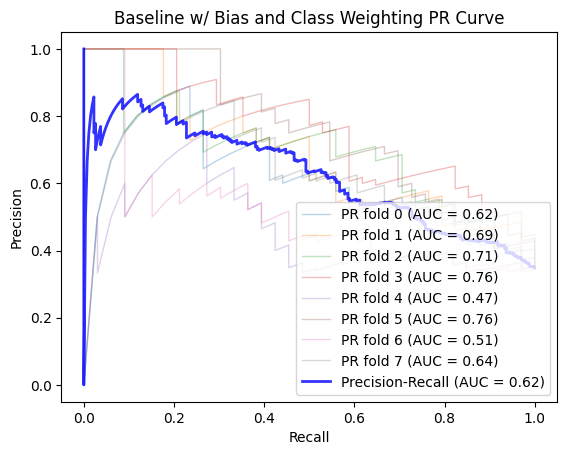

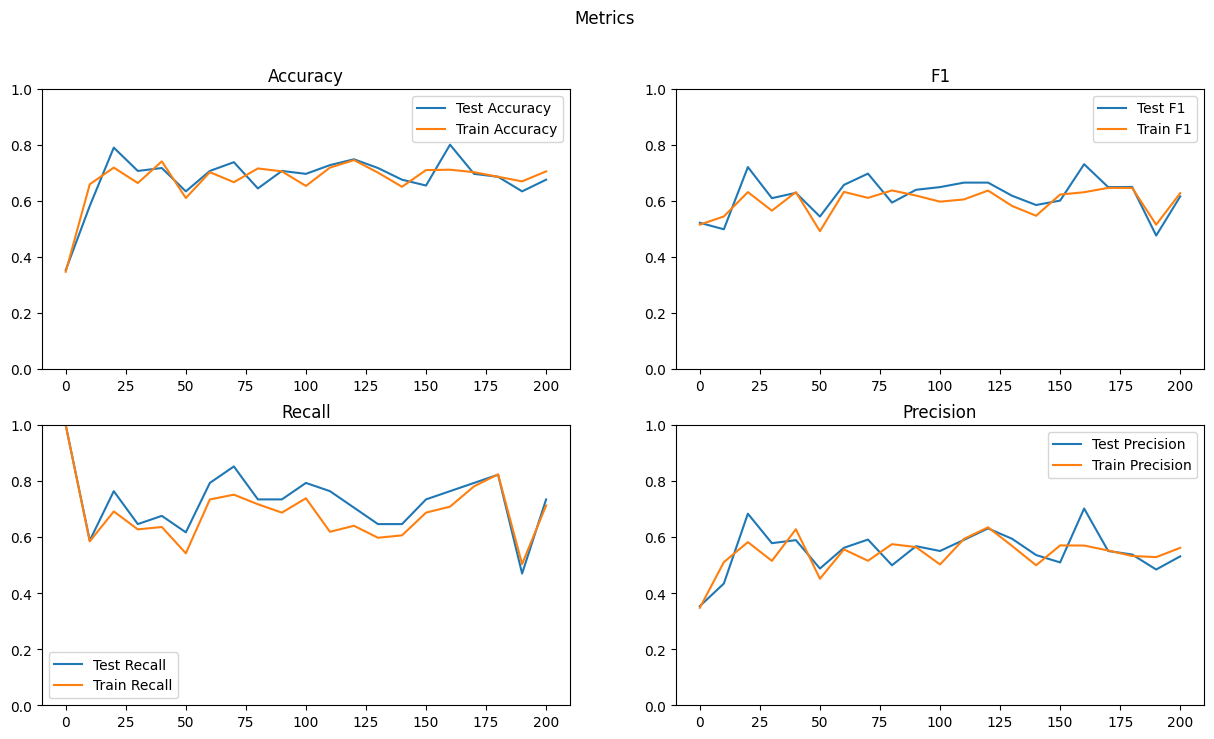

In [53]:
table_metrics(class_weights_fold_evals)
plot_pr_curve([test_dataset for _, test_dataset in folds], class_weights_fold_models, 'Baseline w/ Bias and Class Weighting')
plot_evals_subplot(class_weights_fold_evals[0][0], class_weights_fold_evals[0][1])

##### Gradient Descent w/ Sigmoid Activation

In [61]:
lr = 0.001
epochs = 40
sigmoid_gd_fold_evals = []
sigmoid_gd_fold_models = []

for i, (train_dataset, test_dataset) in enumerate(folds):
    print(f"Fold {i}")

    class_weights = calc_class_weights(train_dataset)
    model = PerceptronWithGD(len(train_dataset[0][0]), 0.02, class_weights=class_weights)
    epoch = 0

    test_evals, train_evals = train_model(
        model.update, model.predict, train_dataset, test_dataset, epoch, epochs, lr, 10)

    sigmoid_gd_fold_evals.append((test_evals, train_evals))
    sigmoid_gd_fold_models.append(model)

Fold 0
Class weights: 0.7671232876712328, 1.435897435897436
t=10 Test Acc: 0.677 Train Acc: 0.696
t=20 Test Acc: 0.719 Train Acc: 0.735
t=30 Test Acc: 0.729 Train Acc: 0.754
t=40 Test Acc: 0.729 Train Acc: 0.754
Fold 1
Class weights: 0.7671232876712328, 1.435897435897436
t=10 Test Acc: 0.771 Train Acc: 0.688
t=20 Test Acc: 0.812 Train Acc: 0.741
t=30 Test Acc: 0.792 Train Acc: 0.746
t=40 Test Acc: 0.802 Train Acc: 0.753
Fold 2
Class weights: 0.7671232876712328, 1.435897435897436
t=10 Test Acc: 0.750 Train Acc: 0.751
t=20 Test Acc: 0.771 Train Acc: 0.756
t=30 Test Acc: 0.771 Train Acc: 0.756
t=40 Test Acc: 0.771 Train Acc: 0.763
Fold 3
Class weights: 0.7671232876712328, 1.435897435897436
t=10 Test Acc: 0.708 Train Acc: 0.747
t=20 Test Acc: 0.719 Train Acc: 0.757
t=30 Test Acc: 0.729 Train Acc: 0.766
t=40 Test Acc: 0.740 Train Acc: 0.768
Fold 4
Class weights: 0.7688787185354691, 1.4297872340425533
t=10 Test Acc: 0.604 Train Acc: 0.702
t=20 Test Acc: 0.656 Train Acc: 0.741
t=30 Test Acc: 

       epoch  accuracy        f1    recall  precision
count    8.0  8.000000  8.000000  8.000000   8.000000
mean    40.0  0.751302  0.670245  0.723930   0.626537
std      0.0  0.052362  0.069571  0.080206   0.074911
min     40.0  0.656250  0.521739  0.545455   0.500000
25%     40.0  0.726562  0.655833  0.705882   0.591304
50%     40.0  0.755208  0.676190  0.735294   0.621951
75%     40.0  0.778646  0.708186  0.787879   0.678571
max     40.0  0.822917  0.753623  0.787879   0.722222


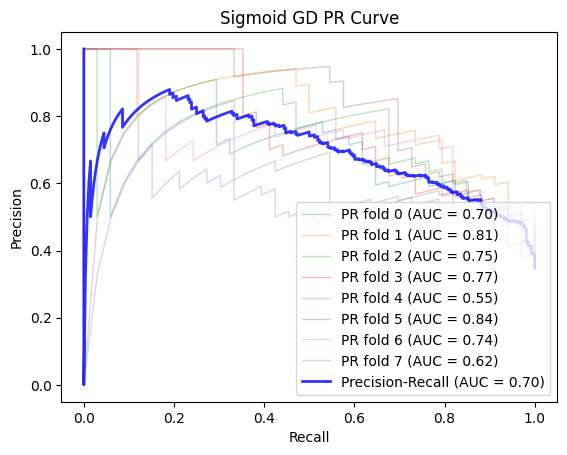

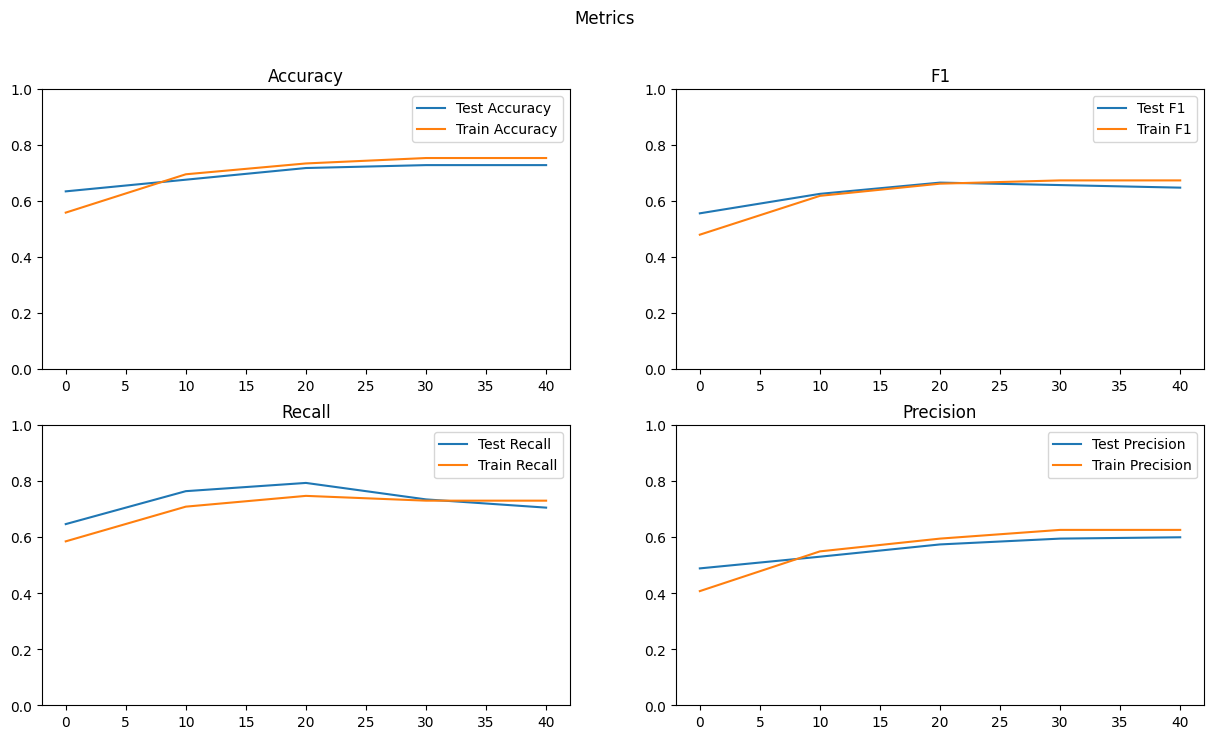

In [62]:
table_metrics(sigmoid_gd_fold_evals)
plot_pr_curve([test_dataset for _, test_dataset in folds], sigmoid_gd_fold_models, 'Sigmoid GD')
for test_evals, train_evals in sigmoid_gd_fold_evals:
    plot_evals_subplot(test_evals, train_evals)
    break

##### GD with Learning Rate Decay

In [26]:
lr = 0.1
lr_decay = 0.9
epochs = 400
step = 10
gd_lr_decay_fold_evals = []
gd_lr_decay_fold_models = []

for i, (train_dataset, test_dataset) in enumerate(folds):
    print(f"Fold {i}")

    class_weights = calc_class_weights(train_dataset)
    model = PerceptronWithGD(len(train_dataset[0][0]), 0.02, class_weights=class_weights)
    epoch = 0

    test_evals, train_evals = train_model(
        model.update, model.predict, train_dataset, test_dataset, epoch, epochs, lr, 10, lr_decay=lr_decay, step=step)

    gd_lr_decay_fold_evals.append((test_evals, train_evals))
    gd_lr_decay_fold_models.append(model)

Fold 0
Class weights: 0.7671232876712328, 1.435897435897436
t=10 Test Acc: 0.708 Train Acc: 0.704
t=20 Test Acc: 0.688 Train Acc: 0.720
t=30 Test Acc: 0.667 Train Acc: 0.674
t=40 Test Acc: 0.677 Train Acc: 0.664
t=50 Test Acc: 0.719 Train Acc: 0.690
t=60 Test Acc: 0.573 Train Acc: 0.603
t=70 Test Acc: 0.677 Train Acc: 0.695
t=80 Test Acc: 0.729 Train Acc: 0.662
t=90 Test Acc: 0.604 Train Acc: 0.632
t=100 Test Acc: 0.708 Train Acc: 0.716
t=110 Test Acc: 0.677 Train Acc: 0.713
t=120 Test Acc: 0.552 Train Acc: 0.560
t=130 Test Acc: 0.708 Train Acc: 0.711
t=140 Test Acc: 0.677 Train Acc: 0.699
t=150 Test Acc: 0.656 Train Acc: 0.692
t=160 Test Acc: 0.677 Train Acc: 0.693
t=170 Test Acc: 0.635 Train Acc: 0.659
t=180 Test Acc: 0.698 Train Acc: 0.738
t=190 Test Acc: 0.698 Train Acc: 0.726
t=200 Test Acc: 0.708 Train Acc: 0.737
t=210 Test Acc: 0.729 Train Acc: 0.750
t=220 Test Acc: 0.760 Train Acc: 0.766
t=230 Test Acc: 0.729 Train Acc: 0.765
t=240 Test Acc: 0.729 Train Acc: 0.763
t=250 Test Ac

       epoch  accuracy        f1    recall  precision
count    8.0  8.000000  8.000000  8.000000   8.000000
mean   400.0  0.746094  0.663847  0.720254   0.618453
std      0.0  0.045554  0.063110  0.083398   0.063010
min    400.0  0.666667  0.529412  0.545455   0.514286
25%    400.0  0.723958  0.647222  0.698529   0.584726
50%    400.0  0.750000  0.671805  0.735294   0.624060
75%    400.0  0.781250  0.708169  0.765152   0.668919
max    400.0  0.802083  0.724638  0.818182   0.694444


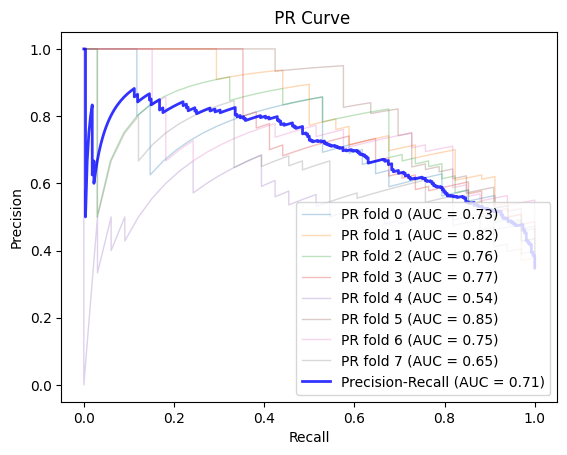

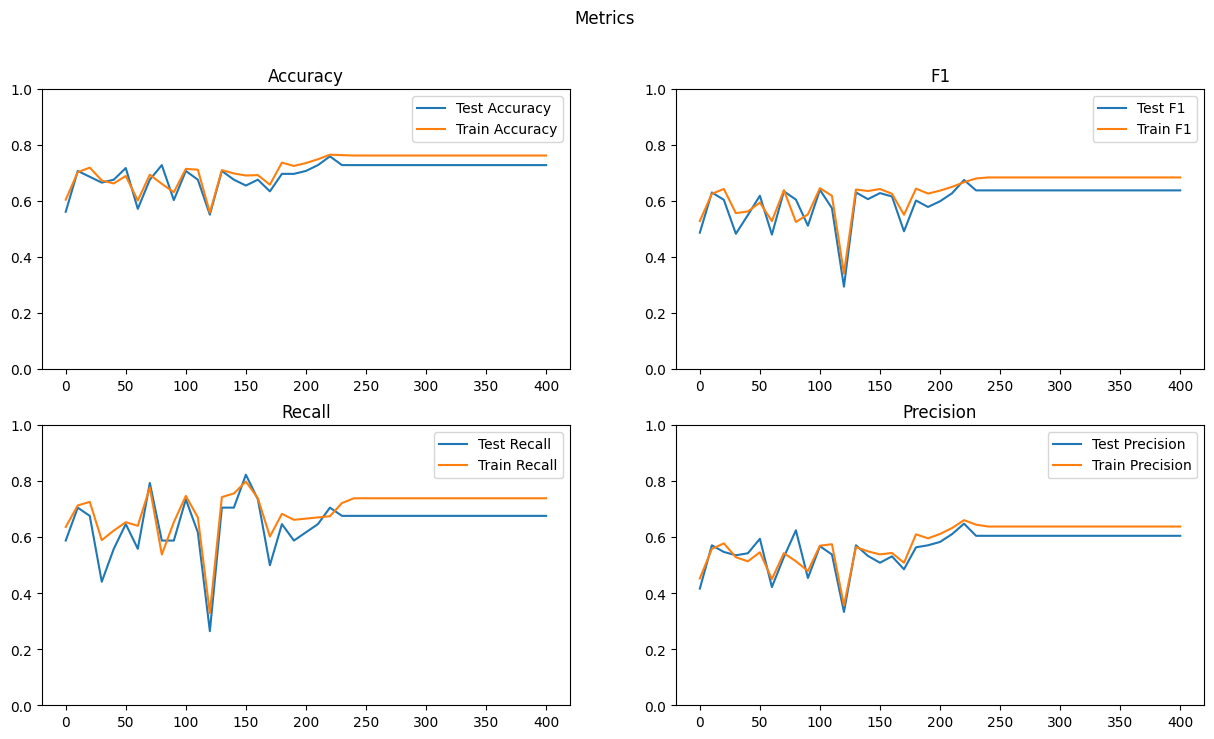

In [27]:
table_metrics(gd_lr_decay_fold_evals)
plot_pr_curve([test_dataset for _, test_dataset in folds], gd_lr_decay_fold_models)
for test_evals, train_evals in gd_lr_decay_fold_evals:
    plot_evals_subplot(test_evals, train_evals)
    break

##### GD with Batch Updates

In [28]:
lr = 0.1
lr_decay = 0.9
epochs = 400
step = 10
batch_update_fold_evals = []
batch_update_fold_models = []

for i, (train_dataset, test_dataset) in enumerate(folds):
    print(f"Fold {i}")

    class_weights = calc_class_weights(train_dataset)
    model = PerceptronWithGD(len(train_dataset[0][0]), 0.02, class_weights=class_weights)
    epoch = 0

    test_evals, train_evals = train_model(
        model.batch_update, model.predict, train_dataset, test_dataset, epoch, epochs, lr, 10, lr_decay=lr_decay, step=step)

    batch_update_fold_evals.append((test_evals, train_evals))
    batch_update_fold_models.append(model)

Fold 0
Class weights: 0.7671232876712328, 1.435897435897436
t=10 Test Acc: 0.677 Train Acc: 0.719
t=20 Test Acc: 0.760 Train Acc: 0.762
t=30 Test Acc: 0.750 Train Acc: 0.759
t=40 Test Acc: 0.719 Train Acc: 0.708
t=50 Test Acc: 0.750 Train Acc: 0.771
t=60 Test Acc: 0.740 Train Acc: 0.771
t=70 Test Acc: 0.760 Train Acc: 0.743
t=80 Test Acc: 0.729 Train Acc: 0.731
t=90 Test Acc: 0.750 Train Acc: 0.759
t=100 Test Acc: 0.708 Train Acc: 0.743
t=110 Test Acc: 0.719 Train Acc: 0.735
t=120 Test Acc: 0.760 Train Acc: 0.777
t=130 Test Acc: 0.750 Train Acc: 0.763
t=140 Test Acc: 0.740 Train Acc: 0.754
t=150 Test Acc: 0.708 Train Acc: 0.749
t=160 Test Acc: 0.740 Train Acc: 0.751
t=170 Test Acc: 0.740 Train Acc: 0.747
t=180 Test Acc: 0.740 Train Acc: 0.740
t=190 Test Acc: 0.750 Train Acc: 0.763
t=200 Test Acc: 0.729 Train Acc: 0.754
t=210 Test Acc: 0.740 Train Acc: 0.760
t=220 Test Acc: 0.740 Train Acc: 0.753
t=230 Test Acc: 0.729 Train Acc: 0.753
t=240 Test Acc: 0.740 Train Acc: 0.765
t=250 Test Ac

       epoch  accuracy        f1    recall  precision
count    8.0  8.000000  8.000000  8.000000   8.000000
mean   400.0  0.747396  0.665179  0.720254   0.620933
std      0.0  0.047491  0.064670  0.083398   0.066711
min    400.0  0.666667  0.529412  0.545455   0.514286
25%    400.0  0.723958  0.647222  0.698529   0.584726
50%    400.0  0.750000  0.671805  0.735294   0.624060
75%    400.0  0.781250  0.708169  0.765152   0.668919
max    400.0  0.812500  0.735294  0.818182   0.714286


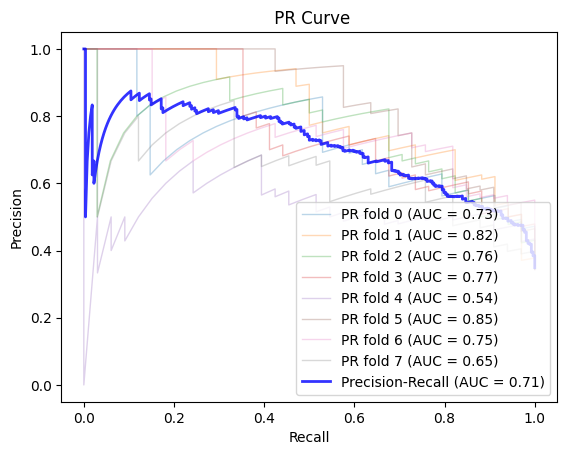

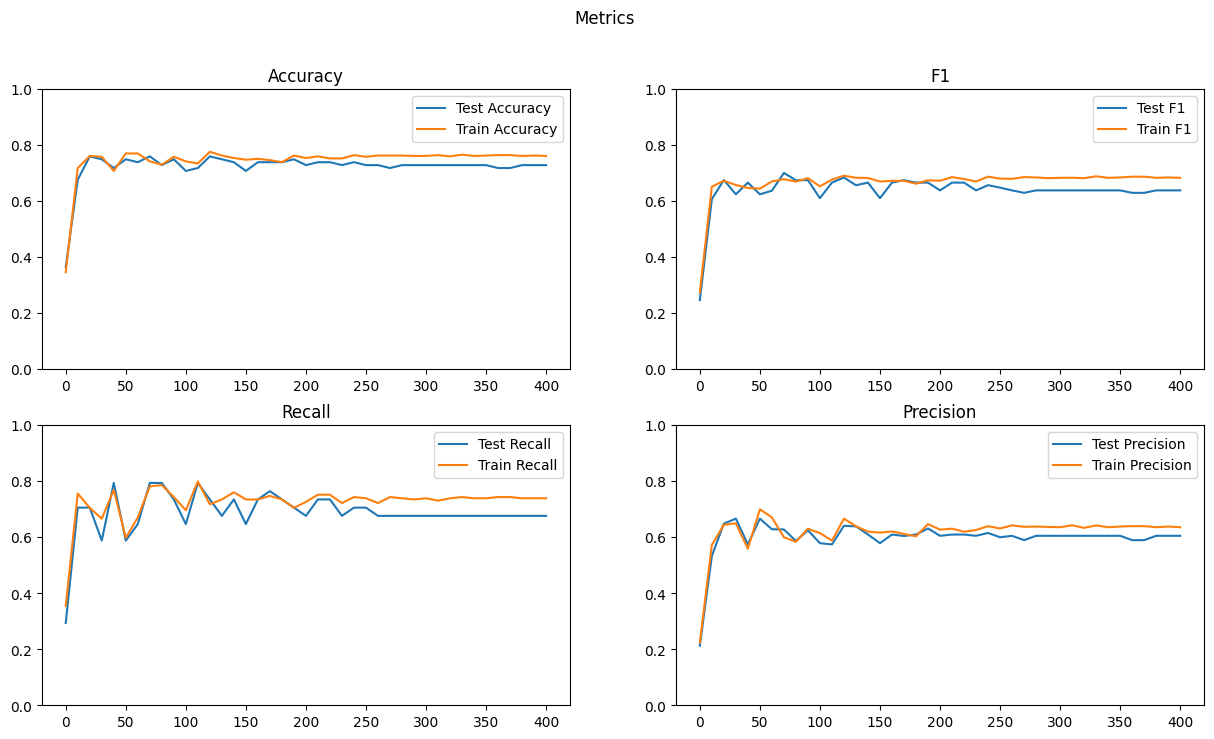

In [29]:
table_metrics(batch_update_fold_evals)
plot_pr_curve([test_dataset for train_dataset,
              test_dataset in folds], batch_update_fold_models)
for test_evals, train_evals in batch_update_fold_evals:
    plot_evals_subplot(test_evals, train_evals)
    break

##### Bias Towards Recall

In [30]:
lr = 0.1
lr_decay = 0.9
epochs = 400
step = 10
recall_fold_evals = []
recall_fold_models = []

for i, (train_dataset, test_dataset) in enumerate(folds):
    print(f"Fold {i}")

    class_weights = calc_class_weights(train_dataset)
    class_weights = class_weights[0], class_weights[1] * 2
    model = PerceptronWithGD(len(train_dataset[0][0]), 0.02, class_weights=class_weights)
    epoch = 0

    test_evals, train_evals = train_model(
        model.batch_update, model.predict, train_dataset, test_dataset, epoch, epochs, lr, 1, lr_decay=lr_decay, step=step)

    recall_fold_evals.append((test_evals, train_evals))
    recall_fold_models.append(model)

Fold 0
Class weights: 0.7671232876712328, 1.435897435897436
t=1 Test Acc: 0.719 Train Acc: 0.732
t=2 Test Acc: 0.719 Train Acc: 0.726
t=3 Test Acc: 0.740 Train Acc: 0.731
t=4 Test Acc: 0.708 Train Acc: 0.719
t=5 Test Acc: 0.656 Train Acc: 0.689
t=6 Test Acc: 0.771 Train Acc: 0.725
t=7 Test Acc: 0.760 Train Acc: 0.737
t=8 Test Acc: 0.740 Train Acc: 0.689
t=9 Test Acc: 0.740 Train Acc: 0.713
t=10 Test Acc: 0.656 Train Acc: 0.652
t=11 Test Acc: 0.625 Train Acc: 0.671
t=12 Test Acc: 0.677 Train Acc: 0.702
t=13 Test Acc: 0.719 Train Acc: 0.702
t=14 Test Acc: 0.615 Train Acc: 0.574
t=15 Test Acc: 0.729 Train Acc: 0.716
t=16 Test Acc: 0.719 Train Acc: 0.717
t=17 Test Acc: 0.719 Train Acc: 0.701
t=18 Test Acc: 0.740 Train Acc: 0.720
t=19 Test Acc: 0.719 Train Acc: 0.693
t=20 Test Acc: 0.625 Train Acc: 0.631
t=21 Test Acc: 0.729 Train Acc: 0.711
t=22 Test Acc: 0.698 Train Acc: 0.634
t=23 Test Acc: 0.708 Train Acc: 0.693
t=24 Test Acc: 0.740 Train Acc: 0.737
t=25 Test Acc: 0.729 Train Acc: 0.722

       epoch  accuracy        f1    recall  precision
count    8.0  8.000000  8.000000  8.000000   8.000000
mean   400.0  0.692708  0.663840  0.869318   0.538129
std      0.0  0.035652  0.036223  0.058127   0.037087
min    400.0  0.635417  0.604651  0.787879   0.482143
25%    400.0  0.669271  0.656949  0.822193   0.509738
50%    400.0  0.708333  0.682086  0.880570   0.554563
75%    400.0  0.718750  0.684417  0.889706   0.559779
max    400.0  0.729167  0.689655  0.969697   0.583333


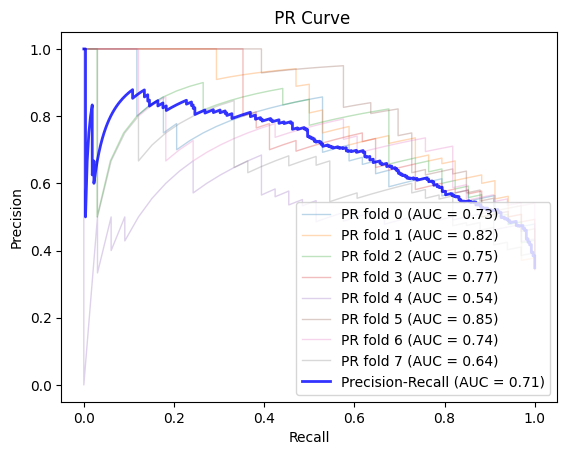

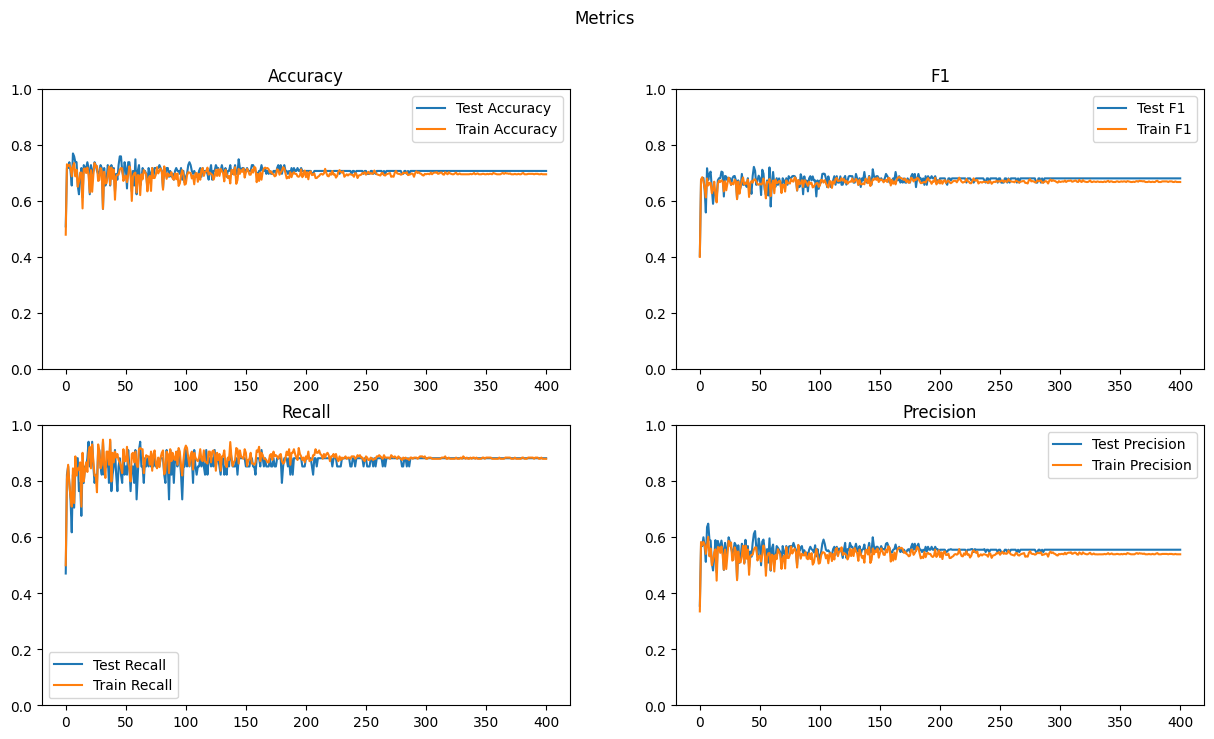

In [31]:
table_metrics(recall_fold_evals)
plot_pr_curve([test_dataset for _, test_dataset in folds], recall_fold_models)
for test_evals, train_evals in recall_fold_evals:
    plot_evals_subplot(test_evals, train_evals)
    break

In [32]:
lr = 0.1
lr_decay = 0.9
epochs = 400
step = 10
tanh_fold_evals = []
tanh_fold_models = []

for i, (train_dataset, test_dataset) in enumerate(folds):
    print(f"Fold {i}")

    class_weights = calc_class_weights(train_dataset)
    model = PerceptronWithGDTanh(len(train_dataset[0][0]), 0.02, class_weights=class_weights)
    epoch = 0

    test_evals, train_evals = train_model(
        model.batch_update, model.predict, train_dataset, test_dataset, epoch, epochs, lr, 1, lr_decay=lr_decay, step=step)

    tanh_fold_evals.append((test_evals, train_evals))
    tanh_fold_models.append(model)

Fold 0
Class weights: 0.7671232876712328, 1.435897435897436
t=1 Test Acc: 0.740 Train Acc: 0.749
t=2 Test Acc: 0.729 Train Acc: 0.723
t=3 Test Acc: 0.719 Train Acc: 0.734
t=4 Test Acc: 0.562 Train Acc: 0.604
t=5 Test Acc: 0.708 Train Acc: 0.749
t=6 Test Acc: 0.677 Train Acc: 0.699
t=7 Test Acc: 0.698 Train Acc: 0.738
t=8 Test Acc: 0.656 Train Acc: 0.618
t=9 Test Acc: 0.594 Train Acc: 0.622
t=10 Test Acc: 0.635 Train Acc: 0.606
t=11 Test Acc: 0.719 Train Acc: 0.720
t=12 Test Acc: 0.719 Train Acc: 0.664
t=13 Test Acc: 0.708 Train Acc: 0.679
t=14 Test Acc: 0.740 Train Acc: 0.734
t=15 Test Acc: 0.677 Train Acc: 0.695
t=16 Test Acc: 0.760 Train Acc: 0.735
t=17 Test Acc: 0.604 Train Acc: 0.702
t=18 Test Acc: 0.562 Train Acc: 0.631
t=19 Test Acc: 0.646 Train Acc: 0.577
t=20 Test Acc: 0.719 Train Acc: 0.722
t=21 Test Acc: 0.740 Train Acc: 0.713
t=22 Test Acc: 0.688 Train Acc: 0.635
t=23 Test Acc: 0.635 Train Acc: 0.690
t=24 Test Acc: 0.740 Train Acc: 0.754
t=25 Test Acc: 0.740 Train Acc: 0.662

       epoch  accuracy        f1    recall  precision
count    8.0  8.000000  8.000000  8.000000   8.000000
mean   400.0  0.746094  0.663810  0.720365   0.618359
std      0.0  0.046564  0.064670  0.086062   0.063432
min    400.0  0.666667  0.529412  0.545455   0.514286
25%    400.0  0.723958  0.647222  0.698529   0.584726
50%    400.0  0.750000  0.671805  0.720588   0.624060
75%    400.0  0.773438  0.694286  0.787879   0.666667
max    400.0  0.812500  0.742857  0.818182   0.702703


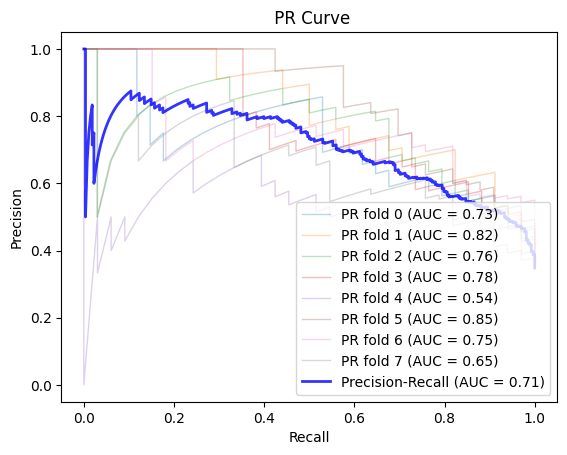

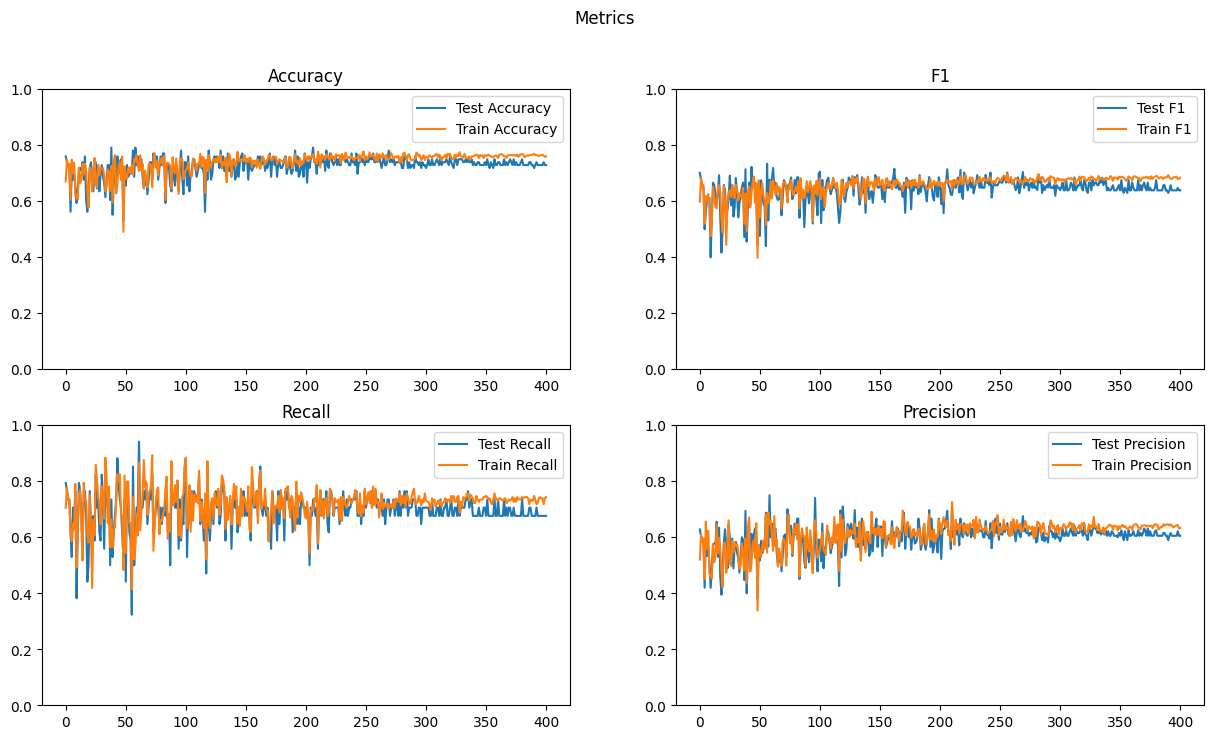

In [33]:
table_metrics(tanh_fold_evals)
plot_pr_curve([test_dataset for _, test_dataset in folds], tanh_fold_models)
for test_evals, train_evals in tanh_fold_evals:
    plot_evals_subplot(test_evals, train_evals)
    break

#### Sources

https://www.geeksforgeeks.org/what-is-perceptron-the-simplest-artificial-neural-network/
https://numpy.org/doc/stable/reference/generated/numpy.sign.html
https://pytorch.org/docs/stable/generated/torch.dot.html
https://datascience.stackexchange.com/questions/26134/initialize-perceptron-weights-with-zero#:~:text=If%20you%20choose%20zero%20initial,z%E2%89%A50%E2%88%921%20otherwise.
https://www.youtube.com/watch?v=4Gac5I64LM4
https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
https://pandas.pydata.org/docs/user_guide/10min.html
https://www.geeksforgeeks.org/normalize-a-column-in-pandas/
https://www.geeksforgeeks.org/what-is-data-normalization/
https://discuss.pytorch.org/t/dataset-from-pandas-without-folder-structure/146816/4
https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
https://medium.com/@douglaspsteen/precision-recall-curves-d32e5b290248
https://stackoverflow.com/questions/29656550/how-to-plot-pr-curve-over-10-folds-of-cross-validation-in-scikit-learn
https://stackoverflow.com/a/41104312
https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
